In [1]:
import torch
from datasets import load_dataset
import webbrowser
import os
from transformer_lens import utils, HookedTransformer
from datasets.arrow_dataset import Dataset
from sae_vis.utils_fns import get_device
from sae_vis.model_fns import AutoEncoder, AutoEncoderConfig
from sae_vis.data_storing_fns import SaeVisData
from sae_vis.data_config_classes import SaeVisConfig
import matplotlib.pyplot as plt

device = get_device()
torch.set_grad_enabled(False);

/Users/joel/code/sae_expected_l0/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
state_dict = torch.load("/Users/joel/Downloads/sae-2.pth", map_location=torch.device('cpu'))

In [3]:
new_state_dict = {
    "W_enc": state_dict["encoder.weight"].T,
    "b_enc": state_dict["encoder.bias"],
    "W_dec": state_dict["decoder.weight"].T,
    "b_dec": state_dict["decoder.bias"],
}

In [4]:
d_hidden, d_in = state_dict["encoder.weight"].shape
cfg = AutoEncoderConfig(d_in=d_in, d_hidden=d_hidden)
encoder = AutoEncoder(cfg)
encoder.load_state_dict(new_state_dict)

for k, v in encoder.named_parameters():
    print(f"{k}: {tuple(v.shape)}")

W_enc: (64, 512)
W_dec: (512, 64)
b_enc: (512,)
b_dec: (64,)


In [5]:
model = HookedTransformer.from_pretrained("roneneldan/TinyStories-1M")
model.to(device);

/Users/joel/code/sae_expected_l0/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model roneneldan/TinyStories-1M into HookedTransformer
Moving model to device:  mps


In [6]:
SEQ_LEN = 128

# Load in the data (it's a Dataset object)
data = load_dataset("roneneldan/TinyStories", split="train")
assert isinstance(data, Dataset)

# Tokenize the data (using a utils function) and shuffle it
tokenized_data = utils.tokenize_and_concatenate(data, model.tokenizer, max_length=SEQ_LEN) # type: ignore
tokenized_data = tokenized_data.shuffle(42)

# Get the tokens as a tensor
all_tokens = tokenized_data["tokens"]
assert isinstance(all_tokens, torch.Tensor)

print(all_tokens.shape)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


torch.Size([3714797, 128])


In [7]:
device

device(type='mps')

In [8]:
model.cfg.device

'mps'

In [9]:
encoder.W_enc.device

device(type='cpu')

In [10]:
encoder.to("mps")

AutoEncoder(d_in=64, dict_mult=8)

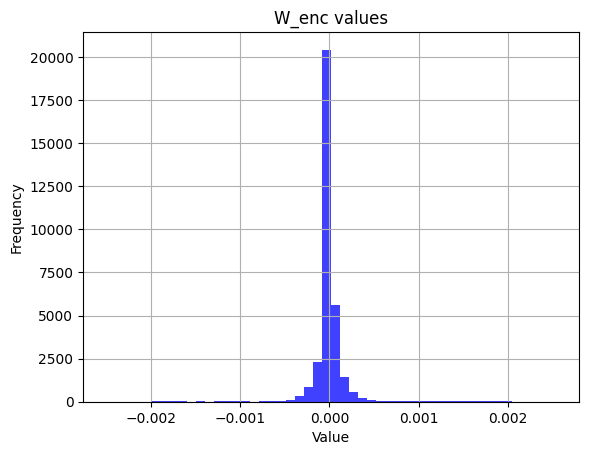

In [11]:
plt.hist(encoder.W_enc.flatten().cpu().detach().numpy(), bins=50, alpha=0.75, color='blue')
plt.title('W_enc values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

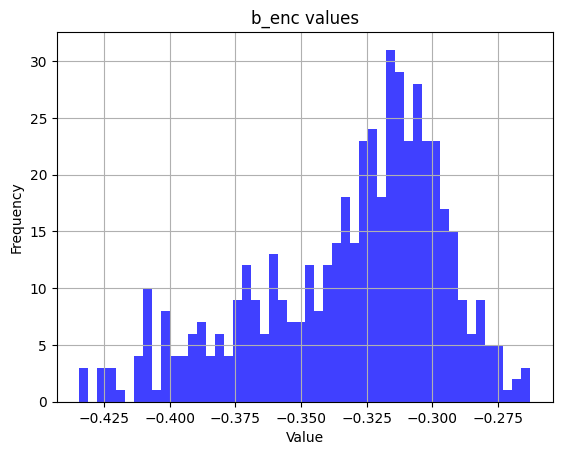

In [12]:
plt.hist(encoder.b_enc.flatten().cpu().detach().numpy(), bins=50, alpha=0.75, color='blue')
plt.title('b_enc values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

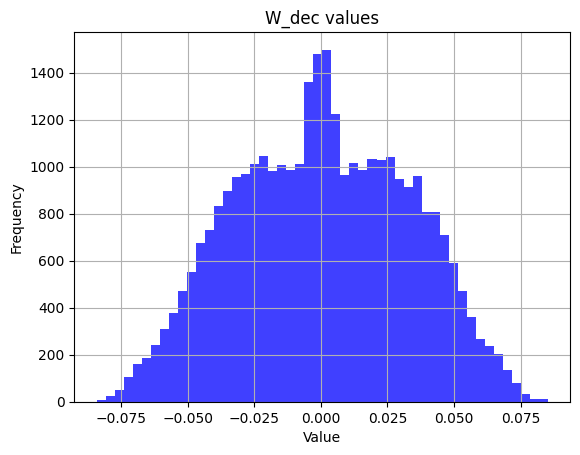

In [13]:
plt.hist(encoder.W_dec.flatten().cpu().detach().numpy(), bins=50, alpha=0.75, color='blue')
plt.title('W_dec values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

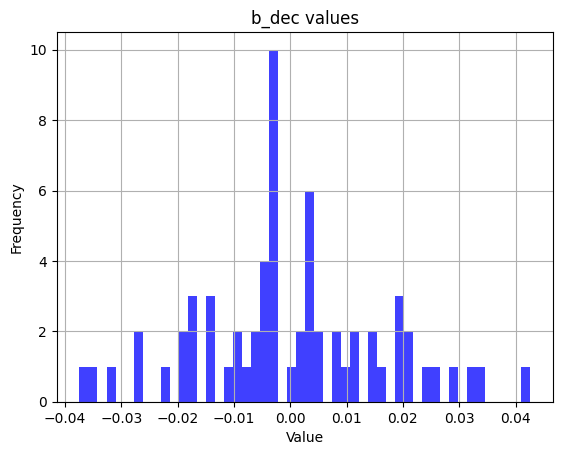

In [14]:
plt.hist(encoder.b_dec.flatten().cpu().detach().numpy(), bins=50, alpha=0.75, color='blue')
plt.title('b_dec values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [15]:
sae_vis_config = SaeVisConfig(
    hook_point = "blocks.4.hook_resid_post",
    features = range(64),
    verbose = True,
)

# Gather the feature data
sae_vis_data = SaeVisData.create(
    encoder = encoder,
    model = model,
    tokens = all_tokens[:2048],
    cfg = sae_vis_config,
)

# Save as HTML file & display vis
filename = "_feature_vis_demo.html"
sae_vis_data.save_feature_centric_vis(filename, feature_idx=8)
webbrowser.open(filename)

Extracting vis data from cached data: 100%|███████████████████████████████████████| 64/64 [00:35<00:00,  3.70it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Task                                           ┃ Time   ┃ Pct % ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ (1) Initialization                             │ 0.09s  │ 0.2%  │
│ (2) Forward passes to gather model activations │ 3.39s  │ 9.3%  │
│ (3) Computing feature acts from model acts     │ 11.47s │ 31.6% │
│ (4) Getting data for tables                    │ 0.13s  │ 0.4%  │
│ (5) Getting data for histograms                │ 2.54s  │ 7.0%  │
│ (6) Getting data for sequences                 │ 18.06s │ 49.7% │
│ (7) Getting data for quantiles                 │ 0.64s  │ 1.8%  │
└────────────────────────────────────────────────┴────────┴───────┘

Saving feature-centric vis: 100%|█████████████████████████████████████████████████| 64/64 [00:00<00:00, 84.69it/s]


True